In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
def loss_function(x_recon, x, mu1, logvar1, mu2, logvar2, mu1_p, logvar1_p):
    # Reconstruction loss (Binary Cross Entropy)
    BCE = F.binary_cross_entropy(x_recon, x.view(-1, 784), reduction='sum')

    # KL divergence between q(z2|z1) and p(z2) ~ N(0, I)
    KLD_z2 = -0.5 * torch.sum(1 + logvar2 - mu2.pow(2) - logvar2.exp())

    # KL divergence between q(z1|x) and p(z1|z2)
    KLD_z1 = -0.5 * torch.sum(
        1 + logvar1 - logvar1_p - ((mu1 - mu1_p).pow(2) + logvar1.exp()) / logvar1_p.exp()
    )

    return BCE + KLD_z1 + KLD_z2


In [3]:
import pymc as pm
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the data
labels_data_path = 'labels_data.csv'
power_bands_data_path = 'left_amygdala_power_bands.csv'

labels_data = pd.read_csv(labels_data_path)
power_bands_data = pd.read_csv(power_bands_data_path)

# Preprocess the data
scaler = StandardScaler()

# Normalize the power bands data
power_bands_scaled = scaler.fit_transform(power_bands_data)

# Combine labels with features
labels = labels_data.iloc[:, 0].values
data_with_labels = np.column_stack((labels, power_bands_scaled))

# Separate labels and features for modeling
observed_features = data_with_labels[:, 1:]
n_samples, n_features = observed_features.shape

# Define the model
with pm.Model() as hierarchical_latent_variable_model:
    # Group-level (global) parameters
    mu_group = pm.Normal("mu_group", mu=0, sigma=1, shape=n_features)
    sigma_group = pm.HalfNormal("sigma_group", sigma=1, shape=n_features)

    # Individual-level latent variables
    mu_individual = pm.Normal(
        "mu_individual", mu=mu_group, sigma=sigma_group, shape=(n_samples, n_features)
    )

    # Observation-level noise
    sigma_observation = pm.HalfNormal("sigma_observation", sigma=1)

    # Observed data likelihood
    observed = pm.Normal(
        "observed", mu=mu_individual, sigma=sigma_observation, observed=observed_features
    )

    # Inference
    trace = pm.sample(1000, return_inferencedata=True)

# # Plot the results
# with hierarchical_latent_variable_model:
#     pm.plot_trace(trace)
#     plt.show()


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_group, sigma_group, mu_individual, sigma_observation]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
There were 314 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [4]:
hierarchical_latent_variable_model

         mu_group ~ Normal(0, 1)
      sigma_group ~ HalfNormal(0, 1)
    mu_individual ~ Normal(mu_group, sigma_group)
sigma_observation ~ HalfNormal(0, 1)
         observed ~ Normal(mu_individual, sigma_observation)

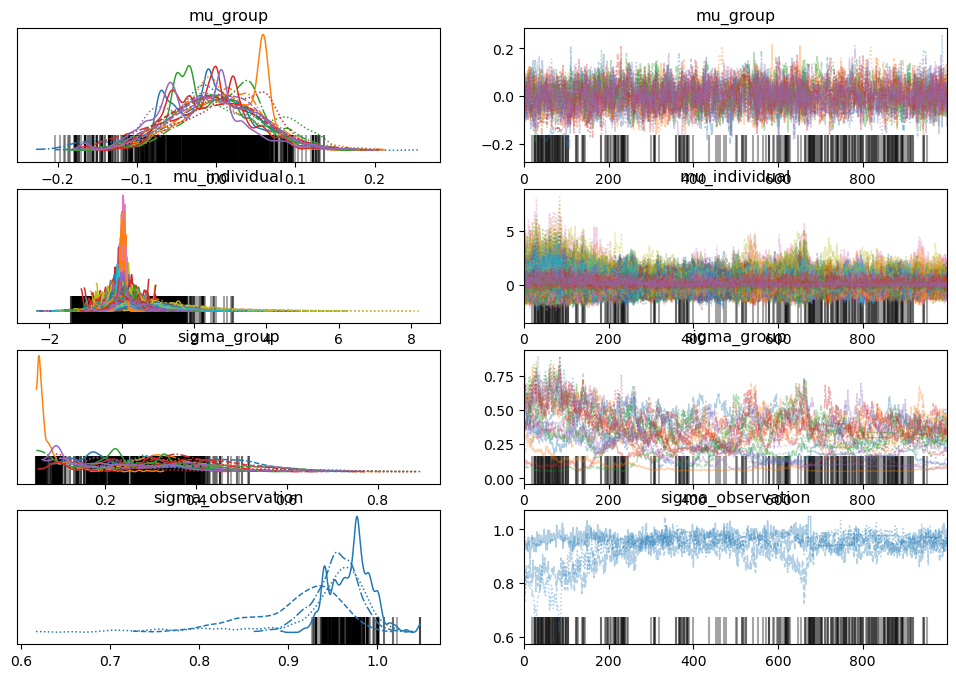

<Figure size 640x480 with 0 Axes>

In [5]:
with hierarchical_latent_variable_model:
    pm.plot_trace(trace)
    plt.show()

plt.tight_layout()

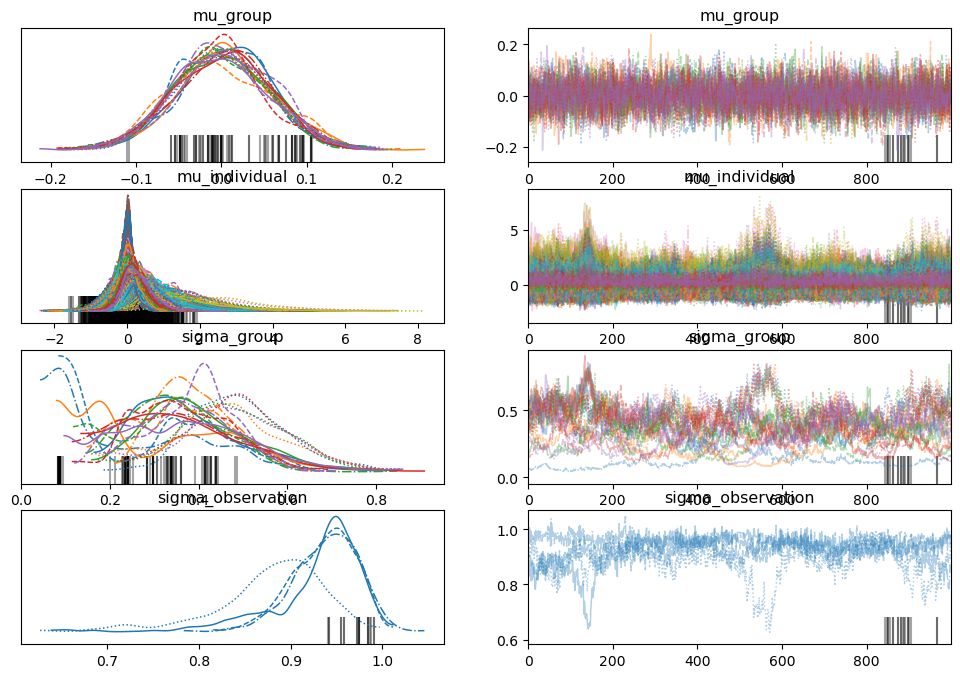

<Figure size 640x480 with 0 Axes>

In [ ]:
with hierarchical_latent_variable_model:
    pm.plot_trace(trace)
    plt.show()

plt.tight_layout()

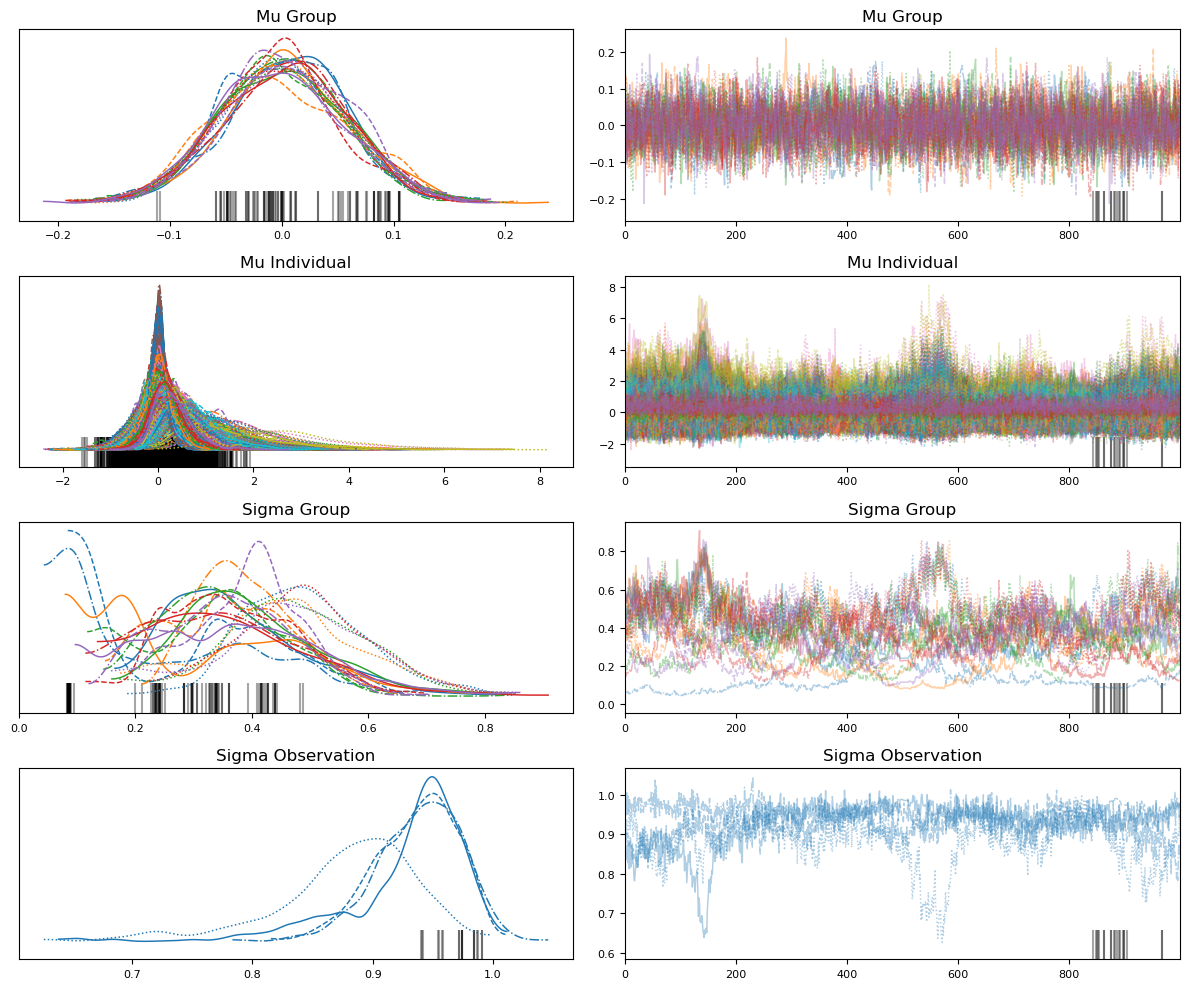

In [13]:
import matplotlib.pyplot as plt

# Plot the trace without specifying axes
axes = pm.plot_trace(trace, figsize=(12, 10))

# Iterate through each axis to adjust titles and labels
for ax in axes.flatten():
    if ax.get_title():
        ax.set_title(ax.get_title().title().replace("_", " "), fontsize=12)  # Capitalize each word
    if ax.get_xlabel():
        ax.set_xlabel(ax.get_xlabel().title(), fontsize=10)  # Fix x-axis label
    if ax.get_ylabel():
        ax.set_ylabel(ax.get_ylabel().title(), fontsize=10)  # Fix y-axis label
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [15]:
mu_individual_posterior.shape

(4, 1000, 319, 5)

/Users/jacobyeung/miniforge3/envs/ml/lib/python3.10/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (1595) in plot_posterior, generating only 40 plots
  warnings.warn(


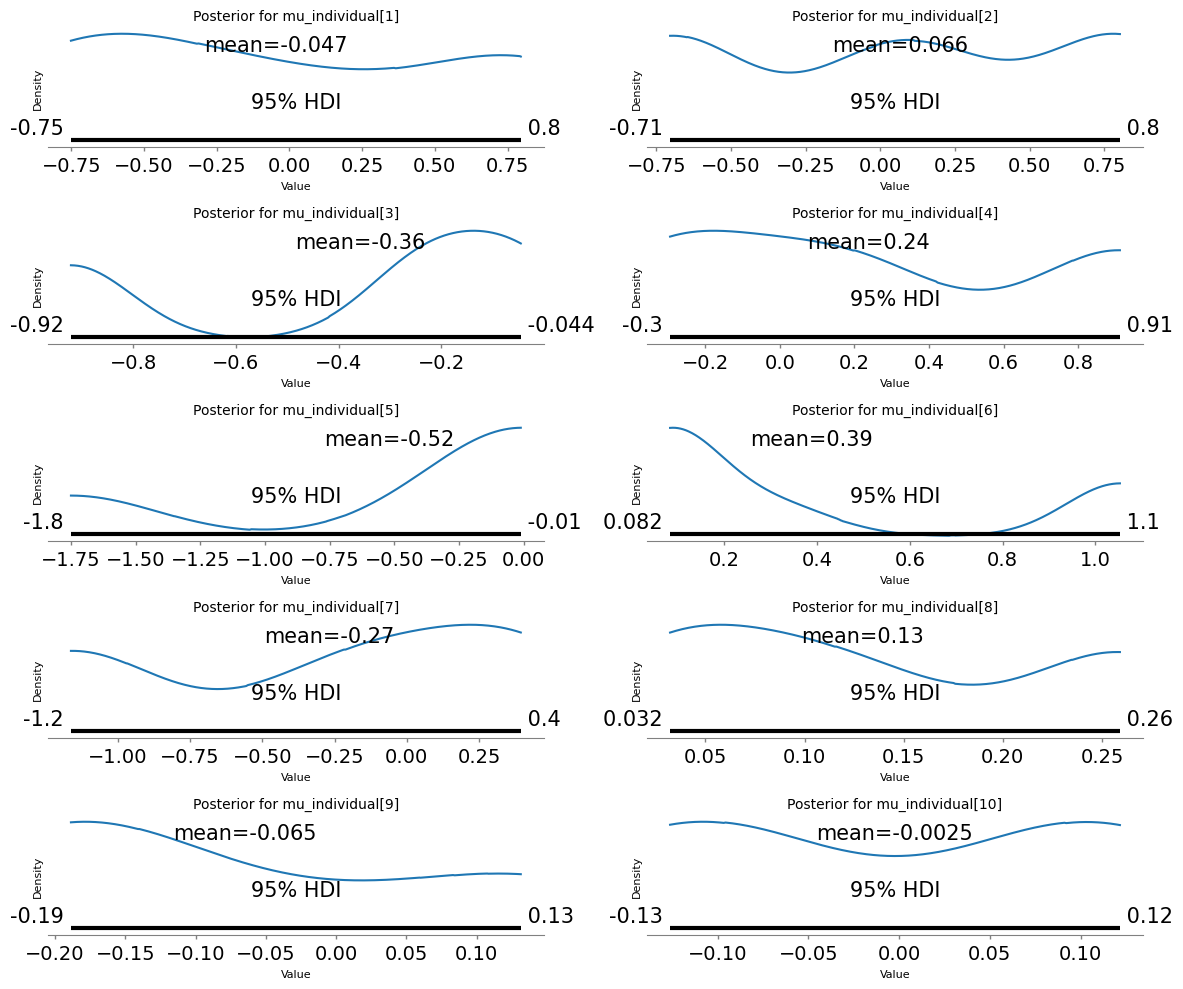

In [14]:
import arviz as az
import matplotlib.pyplot as plt

# Extract posterior samples for mu_individual
mu_individual_posterior = trace.posterior["mu_individual"]

# Plot the posterior for a subset of individuals (e.g., the first 10)
fig, axes = plt.subplots(5, 2, figsize=(12, 10))  # Adjust rows/cols based on the number of plots
for i, ax in enumerate(axes.flatten()):
    if i >= mu_individual_posterior.shape[1]:  # Avoid indexing beyond available data
        break
    az.plot_posterior(mu_individual_posterior[:, i, :], ax=ax, hdi_prob=0.95)
    ax.set_title(f"Posterior for mu_individual[{i+1}]", fontsize=10)
    ax.set_xlabel("Value", fontsize=8)
    ax.set_ylabel("Density", fontsize=8)

plt.tight_layout()
plt.show()


In [7]:
# Extract posterior means of individual latent variables (mu_individual)
posterior_means = trace.posterior["mu_individual"].mean(("chain", "draw")).values

# Define a simple prediction strategy: classify based on the latent mean (example threshold=0)
predicted_labels = (posterior_means.mean(axis=1) > 0).astype(int)

# True labels
true_labels = labels.astype(int)

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, zero_division=1)
recall = recall_score(true_labels, predicted_labels, zero_division=1)

accuracy, precision, recall

(0.47648902821316613, 0.5774647887323944, 0.2303370786516854)

In [21]:
# Load the data
power_bands_data_path = "power_bands_data.npz"
data = np.load(power_bands_data_path)

# Extract labels and power bands for each brain region
labels = data['labels']
brain_regions = {
    "Left Amygdala": data['left_amygdala_power_bands'],
    "Right Amygdala": data['right_amygdala_power_bands'],
    "Left Hippocampus": data['left_hippocampus_power_bands'],
    "Right Hippocampus": data['right_hippocampus_power_bands'],
    "Left & Right Amygdala": np.hstack([
        data['left_amygdala_power_bands'],
        data['right_amygdala_power_bands']
    ]),
    "Left & Right Hippocampus": np.hstack([
        data['left_hippocampus_power_bands'],
        data['right_hippocampus_power_bands']
    ])
}

# Function to calculate metrics for all, congruent, and incongruent trials
def calculate_metrics(labels, predicted_labels):
    # Congruent trials (label = 1)
    congruent_mask = labels == 1
    congruent_precision = precision_score(labels[congruent_mask], predicted_labels[congruent_mask], zero_division=1)
    congruent_recall = recall_score(labels[congruent_mask], predicted_labels[congruent_mask], zero_division=1)

    # Incongruent trials (label = 0)
    incongruent_mask = labels == 0
    incongruent_precision = precision_score(labels[incongruent_mask], predicted_labels[incongruent_mask], zero_division=1)
    incongruent_recall = recall_score(labels[incongruent_mask], predicted_labels[incongruent_mask], zero_division=1)

    # Overall metrics
    overall_accuracy = accuracy_score(labels, predicted_labels)
    overall_precision = precision_score(labels, predicted_labels, zero_division=1)
    overall_recall = recall_score(labels, predicted_labels, zero_division=1)

    return {
        "Overall": {"Accuracy": overall_accuracy, "Precision": overall_precision, "Recall": overall_recall},
        "Congruent": {"Precision": congruent_precision, "Recall": congruent_recall},
        "Incongruent": {"Precision": incongruent_precision, "Recall": incongruent_recall}
    }

# Function to preprocess and train a model
def train_hierarchical_latent_model(region_name, power_bands, labels):
    print(f"Training model for {region_name}...")
    
    # Normalize the power bands data
    scaler = StandardScaler()
    power_bands_scaled = scaler.fit_transform(power_bands)
    
    # Combine labels with features
    data_with_labels = np.column_stack((labels, power_bands_scaled))
    observed_features = data_with_labels[:, 1:]
    n_samples, n_features = observed_features.shape
    
    # Define the model
    with pm.Model() as model:
        # Group-level (global) parameters
        mu_group = pm.Normal("mu_group", mu=0, sigma=1, shape=n_features)
        sigma_group = pm.HalfNormal("sigma_group", sigma=1, shape=n_features)

        # Individual-level latent variables
        mu_individual = pm.Normal(
            "mu_individual", mu=mu_group, sigma=sigma_group, shape=(n_samples, n_features)
        )

        # Observation-level noise
        sigma_observation = pm.HalfNormal("sigma_observation", sigma=1)

        # Observed data likelihood
        observed = pm.Normal(
            "observed", mu=mu_individual, sigma=sigma_observation, observed=observed_features
        )

        # Inference
        trace = pm.sample(1000, return_inferencedata=True)
    
    # Predict labels based on posterior means
    mu_individual_mean = trace.posterior["mu_individual"].mean(("chain", "draw")).values
    predicted_labels = (mu_individual_mean.mean(axis=1) > 0).astype(int)
    
    # Calculate metrics
    metrics = calculate_metrics(labels, predicted_labels)
    
    return {
        "model": model,
        "trace": trace,
        "metrics": metrics
    }

# Train a model for each brain region and combination
region_results = {}
for region_name, power_bands in brain_regions.items():
    region_results[region_name] = train_hierarchical_latent_model(region_name, power_bands, labels)

# Combine all brain regions into a single dataset
all_power_bands = np.hstack([brain_regions["Left Amygdala"], brain_regions["Right Amygdala"],
                             brain_regions["Left Hippocampus"], brain_regions["Right Hippocampus"]])

# Train a combined model using all regions
combined_results = train_hierarchical_latent_model("All Brain Regions", all_power_bands, labels)

# Collect accuracy results for plotting
formatted_results = {region: results["metrics"]["Overall"]["Accuracy"] * 100 for region, results in region_results.items()}
formatted_results["All Brain Regions"] = combined_results["metrics"]["Overall"]["Accuracy"] * 100


# Print results for each region
for region, results in region_results.items():
    metrics = results["metrics"]
    print(f"\nResults for {region}:")
    print(f"  Overall Accuracy: {metrics['Overall']['Accuracy'] * 100:.2f}%")
    print(f"  Overall Precision: {metrics['Overall']['Precision'] * 100:.2f}%")
    print(f"  Overall Recall: {metrics['Overall']['Recall'] * 100:.2f}%")
    print(f"  Congruent Precision: {metrics['Congruent']['Precision'] * 100:.2f}%")
    print(f"  Congruent Recall: {metrics['Congruent']['Recall'] * 100:.2f}%")
    print(f"  Incongruent Precision: {metrics['Incongruent']['Precision'] * 100:.2f}%")
    print(f"  Incongruent Recall: {metrics['Incongruent']['Recall'] * 100:.2f}%")

# Print results for the combined model
metrics = combined_results["metrics"]
print(f"\nResults for All Brain Regions Combined:")
print(f"  Overall Accuracy: {metrics['Overall']['Accuracy'] * 100:.2f}%")
print(f"  Overall Precision: {metrics['Overall']['Precision'] * 100:.2f}%")
print(f"  Overall Recall: {metrics['Overall']['Recall'] * 100:.2f}%")
print(f"  Congruent Precision: {metrics['Congruent']['Precision'] * 100:.2f}%")
print(f"  Congruent Recall: {metrics['Congruent']['Recall'] * 100:.2f}%")
print(f"  Incongruent Precision: {metrics['Incongruent']['Precision'] * 100:.2f}%")
print(f"  Incongruent Recall: {metrics['Incongruent']['Recall'] * 100:.2f}%")

Initializing NUTS using jitter+adapt_diag...


Training model for Left Amygdala...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_group, sigma_group, mu_individual, sigma_observation]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Training model for Right Amygdala...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_group, sigma_group, mu_individual, sigma_observation]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
There were 1000 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Training model for Left Hippocampus...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_group, sigma_group, mu_individual, sigma_observation]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
There were 751 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Training model for Right Hippocampus...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_group, sigma_group, mu_individual, sigma_observation]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
There were 1685 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Training model for Left & Right Amygdala...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_group, sigma_group, mu_individual, sigma_observation]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
There were 219 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Training model for Left & Right Hippocampus...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_group, sigma_group, mu_individual, sigma_observation]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Training model for All Brain Regions...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_group, sigma_group, mu_individual, sigma_observation]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
There were 1526 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



Results for Left Amygdala:
  Overall Accuracy: 48.12%
  Overall Precision: 59.42%
  Overall Recall: 22.91%
  Congruent Precision: 100.00%
  Congruent Recall: 22.91%
  Incongruent Precision: 0.00%
  Incongruent Recall: 100.00%

Results for Right Amygdala:
  Overall Accuracy: 54.37%
  Overall Precision: 62.41%
  Overall Recall: 46.37%
  Congruent Precision: 100.00%
  Congruent Recall: 46.37%
  Incongruent Precision: 0.00%
  Incongruent Recall: 100.00%

Results for Left Hippocampus:
  Overall Accuracy: 43.75%
  Overall Precision: 49.06%
  Overall Recall: 14.53%
  Congruent Precision: 100.00%
  Congruent Recall: 14.53%
  Incongruent Precision: 0.00%
  Incongruent Recall: 100.00%

Results for Right Hippocampus:
  Overall Accuracy: 54.69%
  Overall Precision: 61.81%
  Overall Recall: 49.72%
  Congruent Precision: 100.00%
  Congruent Recall: 49.72%
  Incongruent Precision: 0.00%
  Incongruent Recall: 100.00%

Results for Left & Right Amygdala:
  Overall Accuracy: 52.81%
  Overall Precision: 

In [29]:
np.fromiter(formatted_results.values(), dtype=float)

array([48.125 , 54.375 , 43.75  , 54.6875, 52.8125, 51.875 , 54.0625])

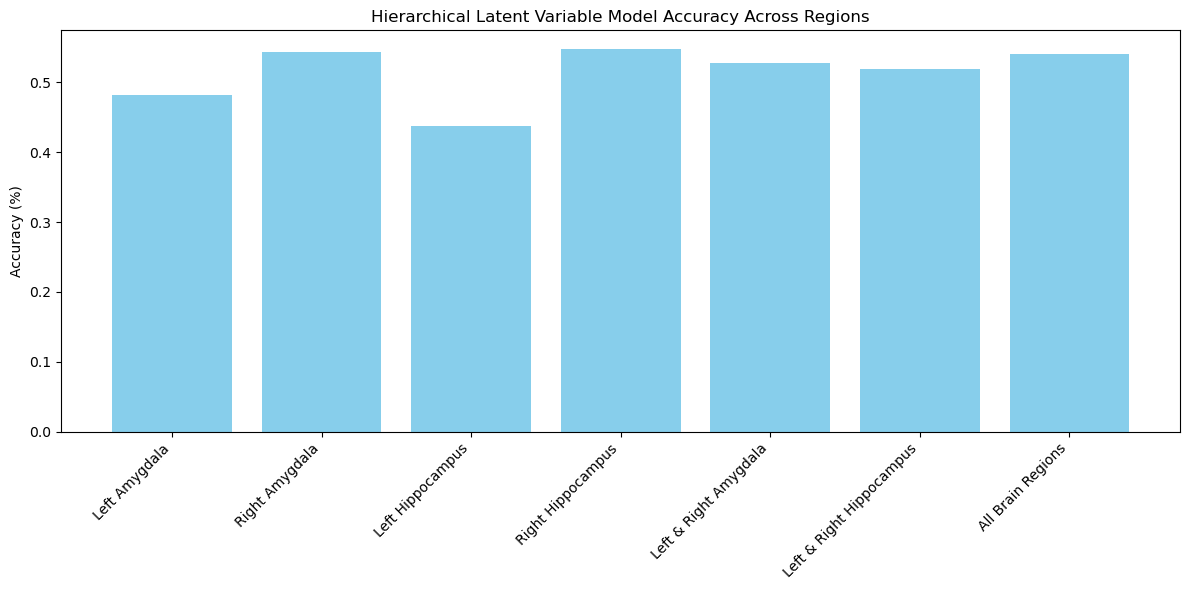

In [30]:

# Plotting the accuracy bar chart
plt.figure(figsize=(12, 6))
plt.bar(formatted_results.keys(), np.fromiter(formatted_results.values(), dtype=float) / 100, color='skyblue')
plt.title('Hierarchical Latent Variable Model Accuracy Across Regions')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('hlvm_accuracy.png', dpi=300)
plt.show()

In [11]:
import arviz as az


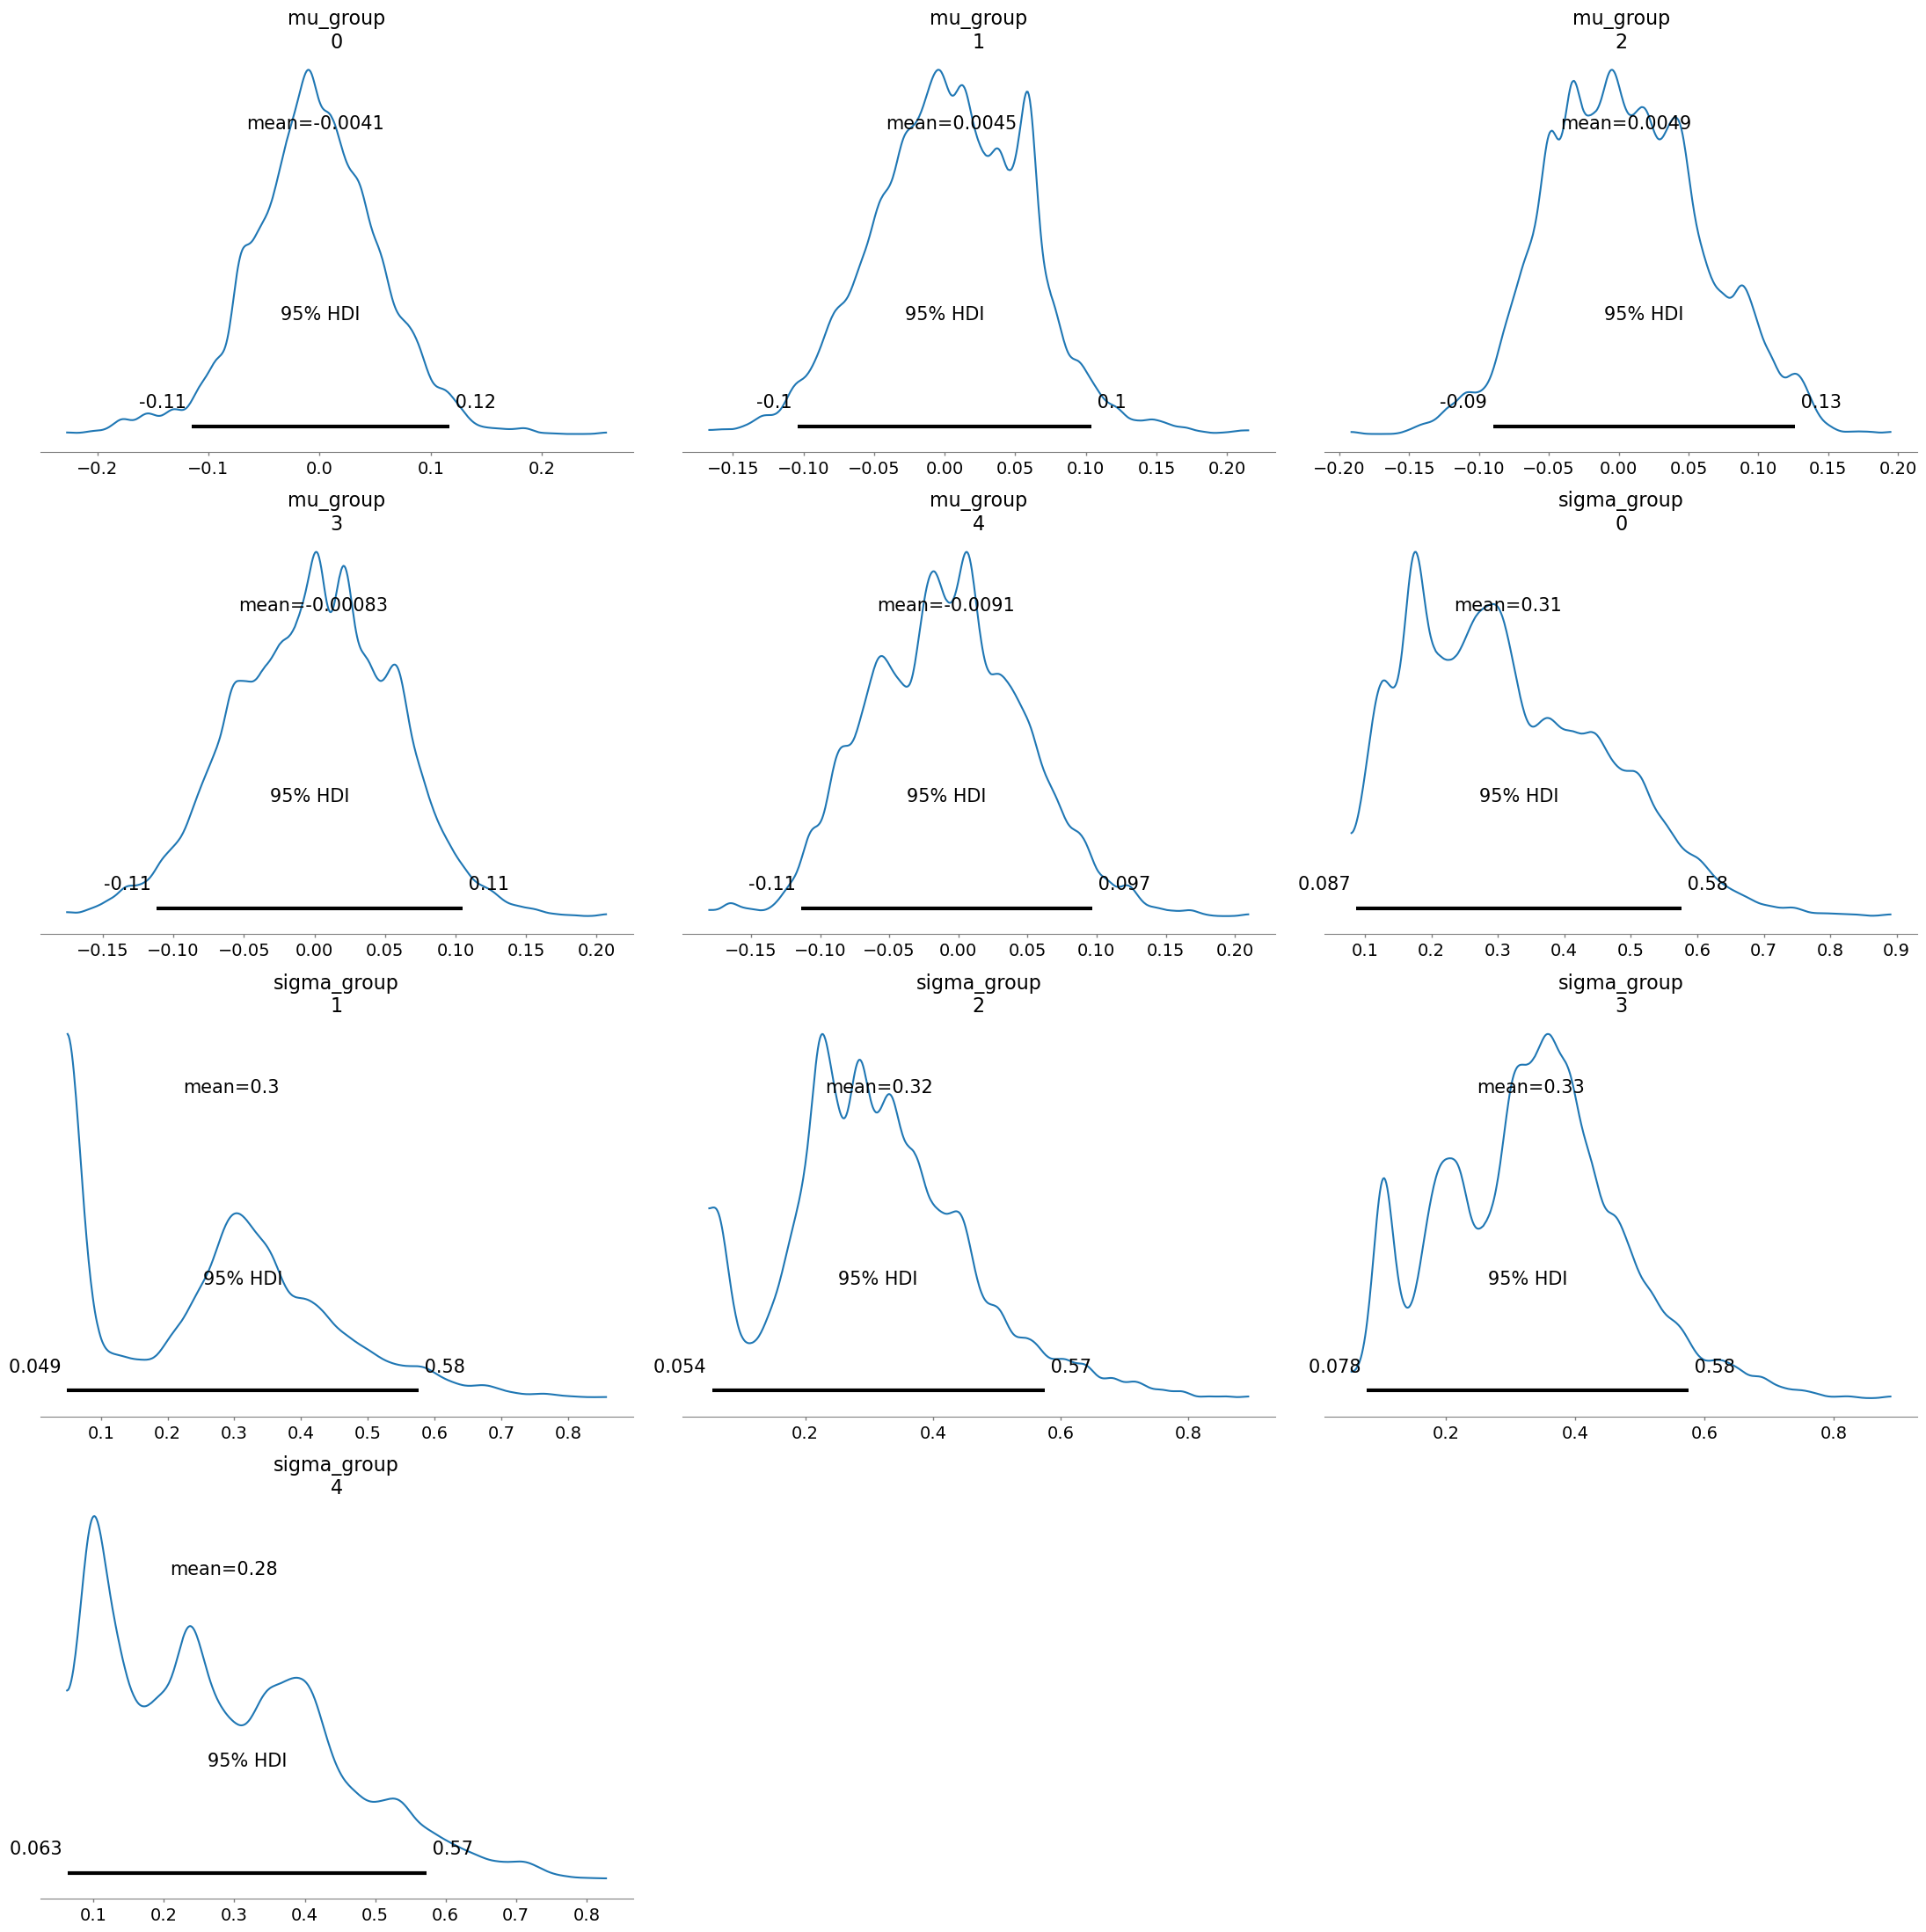

In [14]:
# Plot posterior distributions for mu_group and sigma_group
def plot_group_posteriors(trace):
    """
    Plots posterior distributions for group-level parameters.
    """
    # Density plot for mu_group and sigma_group
    az.plot_posterior(trace, var_names=["mu_group", "sigma_group"], hdi_prob=0.95)
    plt.tight_layout()
    plt.show()

# Plot posteriors for mu_group and sigma_group
plot_group_posteriors(trace)


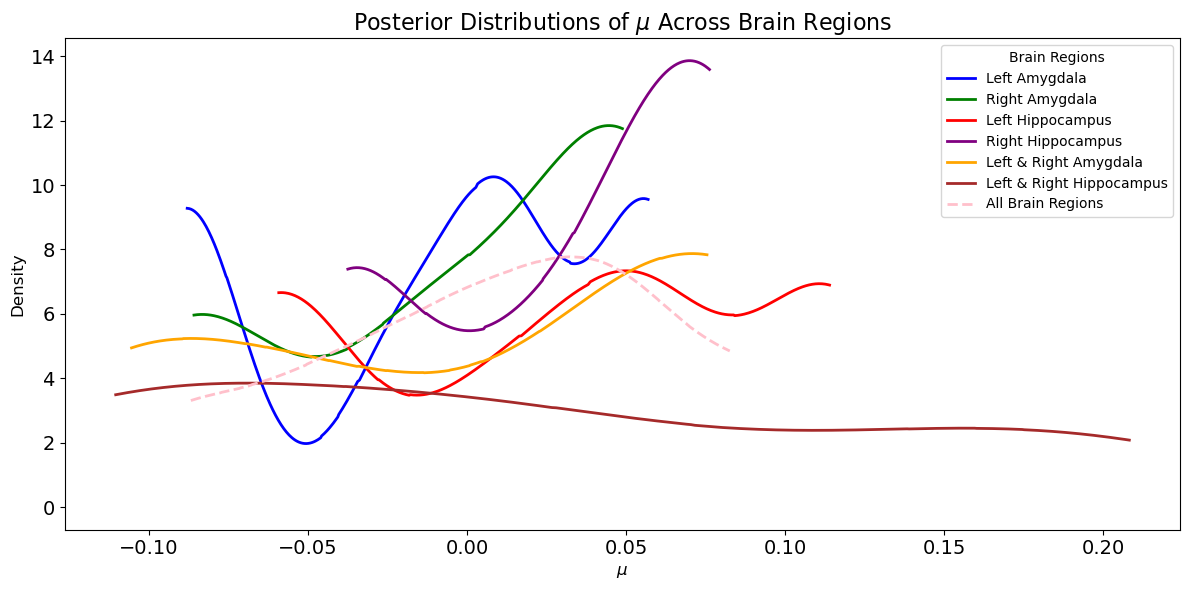

In [41]:
import arviz as az
import matplotlib.pyplot as plt

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink']

# Function to plot all mu_group[0] on the same plot
def plot_all_mu_group_on_same_plot(region_results, combined_results=None):
    """
    Plots posterior distributions of mu_group[0] for all brain region models
    on a single plot with different colors and a legend.
    """
    plt.figure(figsize=(12, 6))

    # Iterate over all regions and plot mu_group[0] on the same plot
    for region_name, results in region_results.items():
        trace = results["trace"]
        first_mu_group_samples = trace.posterior["mu_group"].stack(samples=("chain", "draw"))[:, 0].values
        
        # Plot the posterior density
        az.plot_kde(first_mu_group_samples, label=region_name, plot_kwargs={"linewidth": 2, "color":colors.pop(0)})

    # Optionally include the combined model
    if combined_results is not None:
        combined_trace = combined_results["trace"]
        first_mu_group_combined = combined_trace.posterior["mu_group"].stack(samples=("chain", "draw"))[:, 0].values
        az.plot_kde(first_mu_group_combined, label="All Brain Regions", plot_kwargs={"linewidth": 2, "linestyle": "--", "color":colors.pop(0)})

    # Add plot formatting
    plt.title(r"Posterior Distributions of $\mu$ Across Brain Regions", fontsize=16)
    plt.xlabel(r"$\mu$", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.legend(title="Brain Regions")
    plt.tight_layout()
    plt.savefig('mu_group_posterior_combined_plot.png', dpi=300)
    plt.show()

# Call the function to plot
plot_all_mu_group_on_same_plot(region_results, combined_results=combined_results)


In [ ]:
# Function to calculate precision and recall for congruent and incongruent trials
def calculate_congruent_incongruent_metrics(labels, predicted_labels):
    """
    Calculates precision and recall for congruent (label=1) and incongruent (label=0) trials.
    """
    # Split labels into congruent and incongruent
    congruent_mask = labels == 1
    incongruent_mask = labels == 0

    # Metrics for congruent trials
    congruent_precision = precision_score(labels[congruent_mask], predicted_labels[congruent_mask], zero_division=1)
    congruent_recall = recall_score(labels[congruent_mask], predicted_labels[congruent_mask], zero_division=1)

    # Metrics for incongruent trials
    incongruent_precision = precision_score(labels[incongruent_mask], predicted_labels[incongruent_mask], zero_division=1)
    incongruent_recall = recall_score(labels[incongruent_mask], predicted_labels[incongruent_mask], zero_division=1)

    return {
        "Congruent": {"Precision": congruent_precision, "Recall": congruent_recall},
        "Incongruent": {"Precision": incongruent_precision, "Recall": incongruent_recall},
    }

# Function to extract predictions from the trace and calculate congruent/incongruent metrics
def calculate_metrics_per_model(region_results, labels):
    all_metrics = {}

    for region_name, results in region_results.items():
        print(f"\nCalculating metrics for {region_name}...")
        trace = results["trace"]
        
        # Extract posterior means for mu_individual
        mu_individual_mean = trace.posterior["mu_individual"].mean(("chain", "draw")).values
        
        # Generate predictions by thresholding
        predicted_labels = (mu_individual_mean.mean(axis=1) > 0).astype(int)

        # Calculate congruent and incongruent metrics
        congruent_mask = labels == 1
        incongruent_mask = labels == 0

        congruent_precision = precision_score(labels[congruent_mask], predicted_labels[congruent_mask], zero_division=1)
        congruent_recall = recall_score(labels[congruent_mask], predicted_labels[congruent_mask], zero_division=1)
        incongruent_precision = precision_score(labels[incongruent_mask], predicted_labels[incongruent_mask], zero_division=1)
        incongruent_recall = recall_score(labels[incongruent_mask], predicted_labels[incongruent_mask], zero_division=1)

        all_metrics[region_name] = {
            "Congruent": {"Precision": congruent_precision, "Recall": congruent_recall},
            "Incongruent": {"Precision": incongruent_precision, "Recall": incongruent_recall},
        }

        # Print the metrics
        print(f"  Congruent Precision: {congruent_precision * 100:.2f}%")
        print(f"  Congruent Recall: {congruent_recall * 100:.2f}%")
        print(f"  Incongruent Precision: {incongruent_precision * 100:.2f}%")
        print(f"  Incongruent Recall: {incongruent_recall * 100:.2f}%")

    return all_metrics

# Calculate metrics for each brain region model
region_metrics = calculate_metrics_per_model(region_results, labels)

# Calculate metrics for the combined model
print(f"\nCalculating metrics for All Brain Regions Combined...")
trace = combined_results["trace"]
mu_individual_mean = trace.posterior["mu_individual"].mean(("chain", "draw")).values
predicted_labels = (mu_individual_mean.mean(axis=1) > 0).astype(int)

# Calculate metrics for congruent and incongruent trials
combined_metrics = calculate_congruent_incongruent_metrics(labels, predicted_labels)

# Print combined metrics
print(f"  Congruent Precision: {combined_metrics['Congruent']['Precision'] * 100:.2f}%")
print(f"  Congruent Recall: {combined_metrics['Congruent']['Recall'] * 100:.2f}%")
print(f"  Incongruent Precision: {combined_metrics['Incongruent']['Precision'] * 100:.2f}%")
print(f"  Incongruent Recall: {combined_metrics['Incongruent']['Recall'] * 100:.2f}%")


In [18]:
len(labels), len(predicted_labels)

(320, 320)